<a href="https://colab.research.google.com/github/xRomory/CCMACLRL_COM231ML_PROJECT/blob/dev/fake_news/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-Linguistic Fake News Detection Using Machine Learning: A Comparative Analysis on English and Filipino News Datasets

Import Python Libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


## Datasets

In [7]:
fake_url = "https://github.com/xRomory/CCMACLRL_COM231ML_PROJECT/blob/main/fake_news/datasets/fake_compressed.csv?raw=true"
fake_data = pd.read_csv(fake_url)

fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
true_url = "https://github.com/xRomory/CCMACLRL_COM231ML_PROJECT/blob/main/fake_news/datasets/true_compressed.csv?raw=true"
true_data = pd.read_csv(true_url)

true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
# Combine Both .csv file and add a label to classify real news and fake news dataset

fake_data["Label"], true_data["Label"] = "F", "R"

data = pd.concat([fake_data, true_data], axis=0)
data.head()

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",F
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",F
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",F
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",F
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",F


### Find out what's in the data

In [10]:
data.shape

(44898, 5)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   Label    44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [12]:
data.describe(include=["object"]).T

,count,unique,top,freq
title,44898,38729,Factbox: Trump fills top jobs for his administ...,14
text,44898,38646,,627
subject,44898,8,politicsNews,11272
date,44898,2397,"December 20, 2017",182
Label,44898,2,F,23481


Check for any missing and duplicated values

In [13]:
# Check for missing values
data.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [14]:
#Check for duplicate values
data.duplicated().sum()

np.int64(209)

In [15]:
#See all instances of duplicated rows
data[data.duplicated(keep=False)]

,title,text,subject,date,Label
9941,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",F
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",F
11445,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",F
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",F
14924,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015",F
...,...,...,...,...,...
21290,"Europeans, Africans agree renewed push to tack...",PARIS (Reuters) - Europe s big four continen...,worldnews,"August 28, 2017",R
21345,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",R
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",R
21406,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",R


In [16]:
# Get value counts of Label
data.Label.value_counts()

Label
F    23481
R    21417
Name: count, dtype: int64

### Data Visualization

See the ratio of news subjects inside the datasets

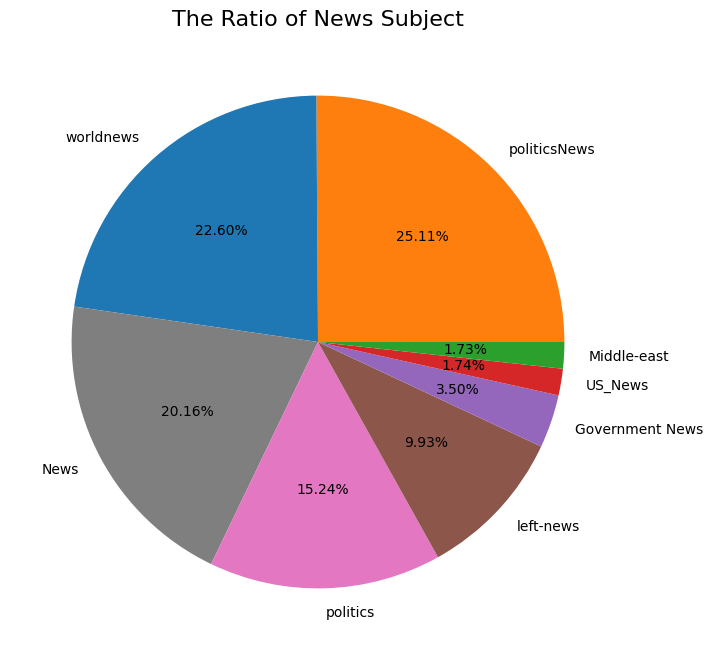

In [17]:
# Color of Pie chart
color_map = {
    "worldnews": "#1f77b4",
    "politicsNews": "#ff7f0e",
    "Middle-east": "#2ca02c",
    "US_News": "#d62728",
    "Government News": "#9467bd",
    "left-news": "#8c564b",
    "politics": "#e377c2",
    "News": "#7f7f7f"
}

subject_count = data["subject"].value_counts()
labels = subject_count.index.to_list()

colors = [color_map[label] for label in labels]
plt.figure(figsize=(8, 8))
plt.pie(
    x=subject_count,
    autopct="%1.2f%%",
    labels=labels,
    colors=colors,
)
plt.title("The Ratio of News Subject", fontsize=16)
plt.show()

See target distribution of our data:

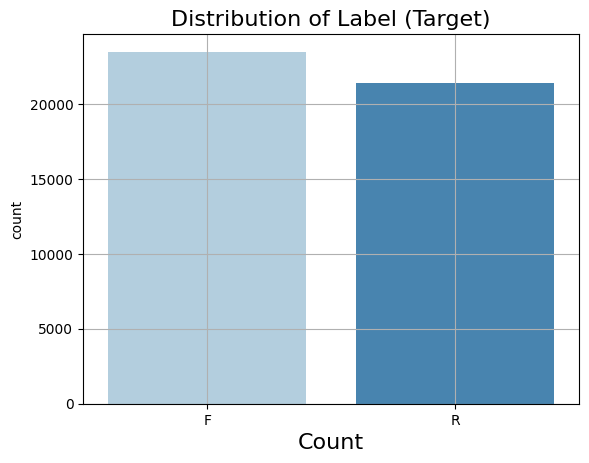

In [18]:
sns.countplot(x=data.Label, data=data, palette="Blues", hue="Label")
plt.title("Distribution of Label (Target)", fontsize=16)
plt.xlabel("Target", fontsize=16)
plt.xlabel("Count", fontsize=16)
plt.grid(True)
plt.show()

See subject counts inside our datasets (Fake, and Real).

In [19]:
data_counts = data.groupby(["subject", "Label"]).size().unstack(fill_value=0)
data_counts

Label,F,R
subject,,
Government News,1570,0
Middle-east,778,0
News,9050,0
US_News,783,0
left-news,4459,0
politics,6841,0
politicsNews,0,11272
worldnews,0,10145


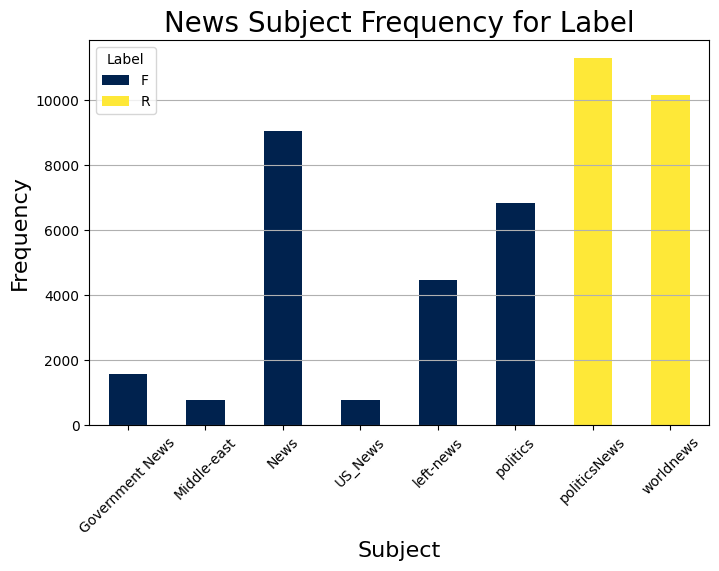

In [20]:
plt.figure(figsize=(8, 5))
data_counts.plot(
    kind="bar",
    stacked=True,
    colormap="cividis",
    ax=plt.gca()
)
plt.title("News Subject Frequency for Label", fontsize=20)
plt.xlabel("Subject", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.show()

See frequent words used in our datasets

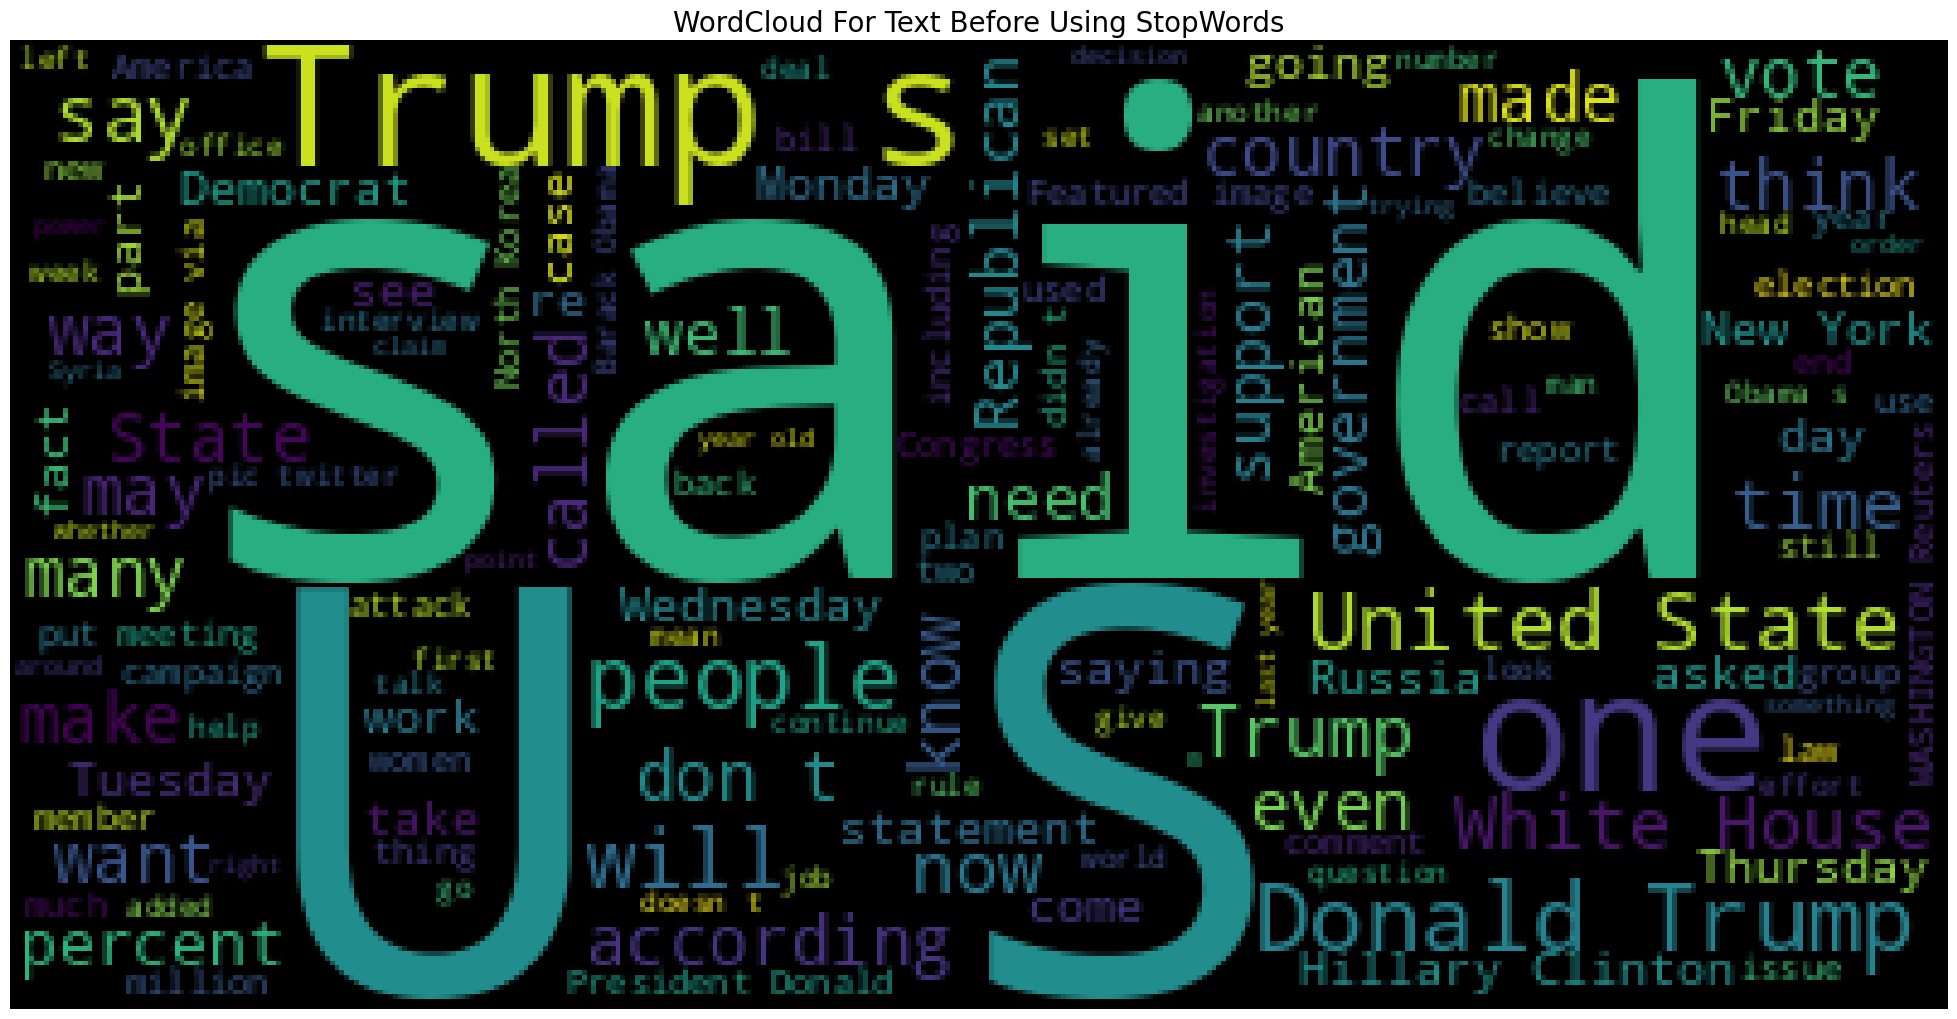

In [21]:
plt.figure(figsize=(25, 15))
plt.imshow(WordCloud(background_color='black').generate(" ".join(data.text)))
plt.axis("off")
plt.title("WordCloud For Text Before Using StopWords", fontsize=20)
plt.show()

### Data pre-processing

A while ago, we noticed that we have duplicated values. So, what we can do is drop them.

In [22]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

np.int64(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   Label    44689 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


Use stopwords to exclude common words

[nltk_data] Downloading package stopwords to /home/romory/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


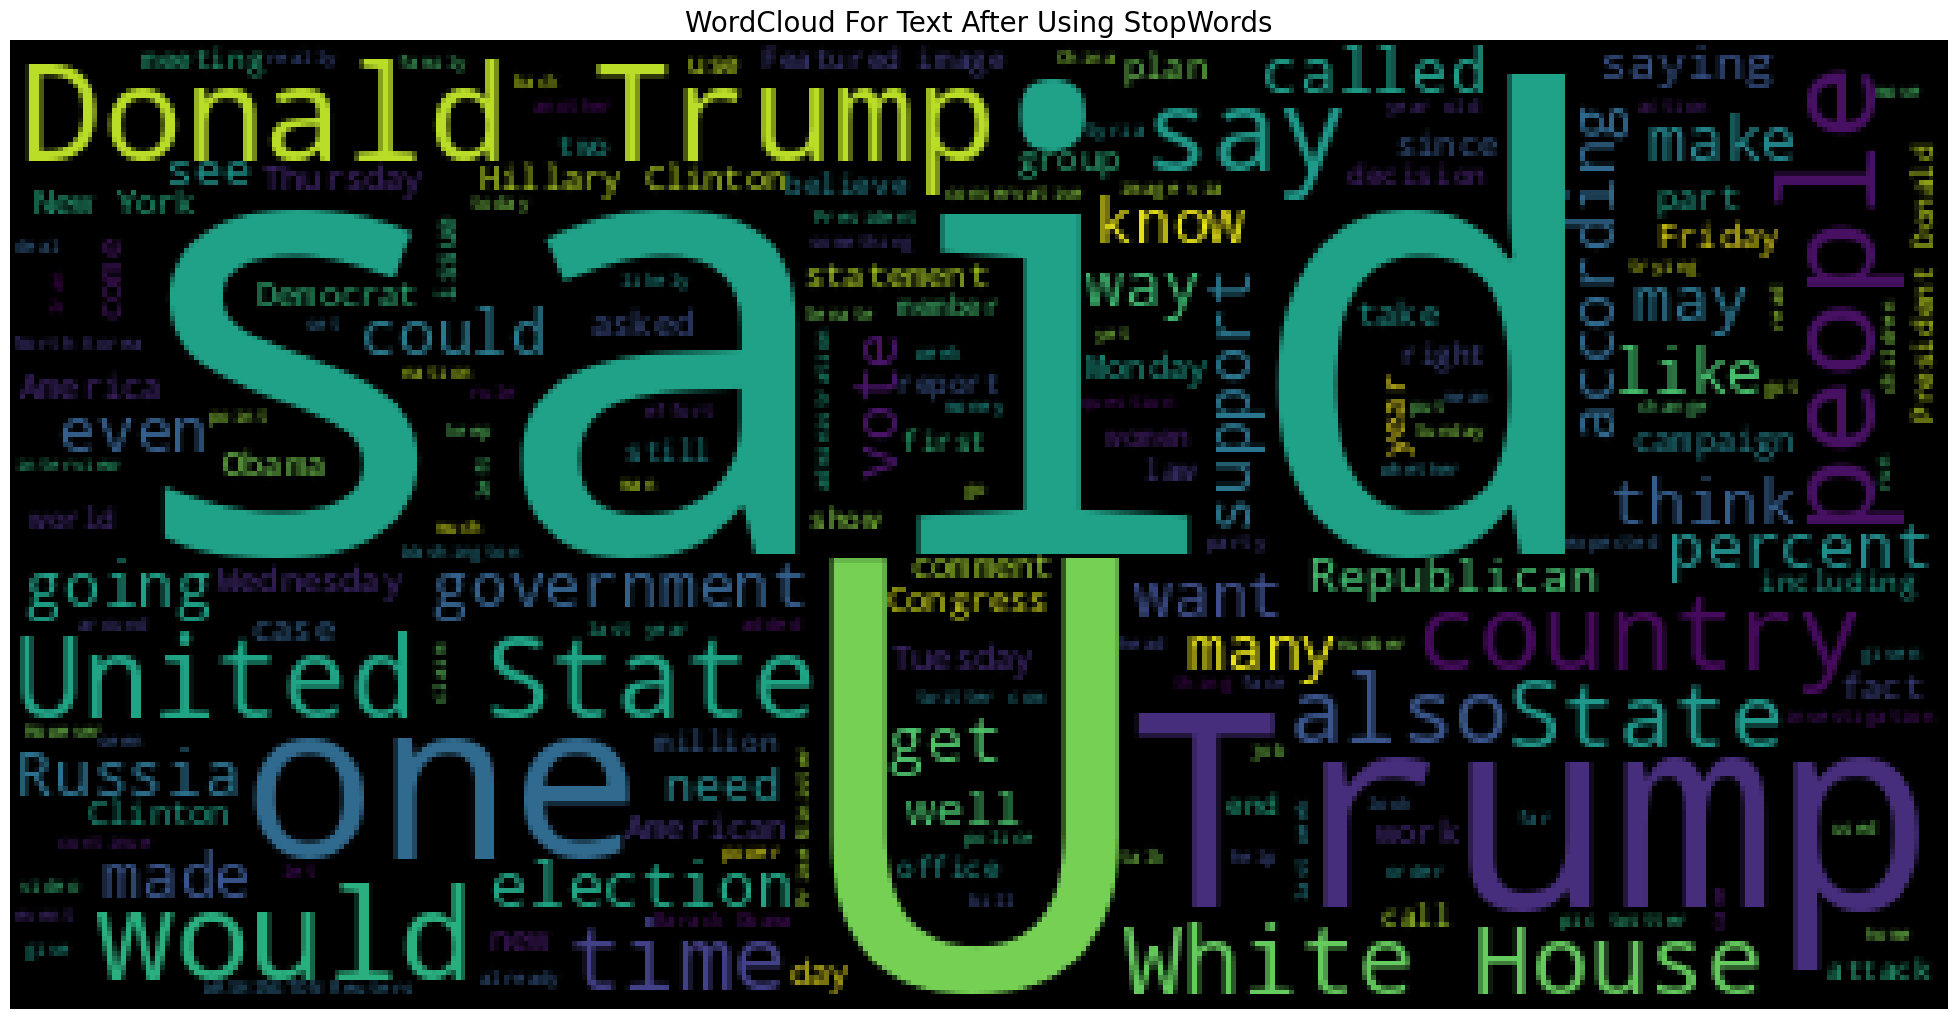

In [24]:
import nltk
nltk.download('stopwords')

plt.figure(figsize=(25, 15))
plt.imshow(
    WordCloud(
        background_color='black',
        stopwords=set(stopwords.words('english'))
    ).generate(" ".join(data.text))
)
plt.axis("off")
plt.title("WordCloud For Text After Using StopWords", fontsize=20)
plt.show()

See data text in our datasets

In [25]:
data_text = data.text
data_text

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
21412    BRUSSELS (Reuters) - NATO allies on Tuesday we...
21413    LONDON (Reuters) - LexisNexis, a provider of l...
21414    MINSK (Reuters) - In the shadow of disused Sov...
21415    MOSCOW (Reuters) - Vatican Secretary of State ...
21416    JAKARTA (Reuters) - Indonesia will buy 11 Sukh...
Name: text, Length: 44689, dtype: object

In [26]:
import re

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    # Remove X user handle starting with "@"
    text=re.sub(r'@\w+', '', text)

    # Remove non-alphanumeric characters and extra whitespaces
    text=re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove multiple whitespaces
    text=re.sub(r'\s+', ' ', text)

    # Convert data text to lowercase
    text = text.lower()

    # Tokenize `text` variable
    words = text.split()

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return " ".join(words)

[nltk_data] Downloading package wordnet to /home/romory/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/romory/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/romory/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
data_text = data_text.apply(normalize_text)
data_text

0        donald trump wish american happy new year leav...
1        house intelligence committee chairman devin nu...
2        friday revealed former milwaukee sheriff david...
3        christmas day donald trump announced would bac...
4        pope francis used annual christmas day message...
                               ...                        
21412    brussels reuters nato ally tuesday welcomed pr...
21413    london reuters lexisnexis provider legal regul...
21414    minsk reuters shadow disused sovietera factory...
21415    moscow reuters vatican secretary state cardina...
21416    jakarta reuters indonesia buy sukhoi fighter j...
Name: text, Length: 44689, dtype: object

In [28]:
data_target = data.Label
data_target

0        F
1        F
2        F
3        F
4        F
        ..
21412    R
21413    R
21414    R
21415    R
21416    R
Name: Label, Length: 44689, dtype: object

In [29]:
# Transform "R" and "F" to a numeric for easy data modeling
data_target.replace('R', 0, inplace=True)
data_target.replace('F', 1, inplace=True)
data_target

/tmp/ipykernel_12368/4231897351.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_target.replace('F', 1, inplace=True)


0        1
1        1
2        1
3        1
4        1
        ..
21412    0
21413    0
21414    0
21415    0
21416    0
Name: Label, Length: 44689, dtype: int64

In [30]:
x_train, x_test, y_train, y_test = train_test_split(
    data_text,
    data_target,
    test_size=0.2,
    random_state=42
)

print("x_train Shape:", x_train.shape)
print("x_test Shape:", x_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

x_train Shape: (35751,)
x_test Shape: (8938,)
y_train Shape: (35751,)
y_test Shape: (8938,)


#### Multinomial Naive Bayes Model

In [31]:
# Find the best parameter for MNB, and TF-IDF

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'mnb__alpha': [0.1, 0.5, 1],
#     'mnb__fit_prior': [True, False],
# }

# grid = GridSearchCV(
#     multi_nb_model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === Output ===
# Best Parameters: {'mnb__alpha': 0.1, 'mnb__fit_prior': True, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}
# Best Cross-Validation Score: 0.9693156162813553

In [32]:
multi_nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,1),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
    )),
    ("mnb", MultinomialNB(
        alpha=0.1,
        fit_prior=True
    )),
])

multi_nb_model.fit(x_train, y_train)

,steps,"[('tfidf', ...), ('mnb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


MultimonialNB Model Check

In [33]:
print("Pipeline Model Train Score:", multi_nb_model.score(x_train, y_train))
print("Pipeline Model Test Score:", multi_nb_model.score(x_test, y_test))

Pipeline Model Train Score: 0.9655114542250567
Pipeline Model Test Score: 0.9578205415081674


In [34]:
y_pred = multi_nb_model.predict(x_test)
df = pd.DataFrame()
df["Actual"], df["Predict"] = y_test, y_pred
df.replace(0, "R", inplace=True)
df.replace(1, "F", inplace=True)
df

,Actual,Predict
17896,F,F
16186,R,R
12959,R,R
21764,F,F
7557,F,F
...,...,...
16296,F,F
4455,R,R
13633,F,F
9704,R,R


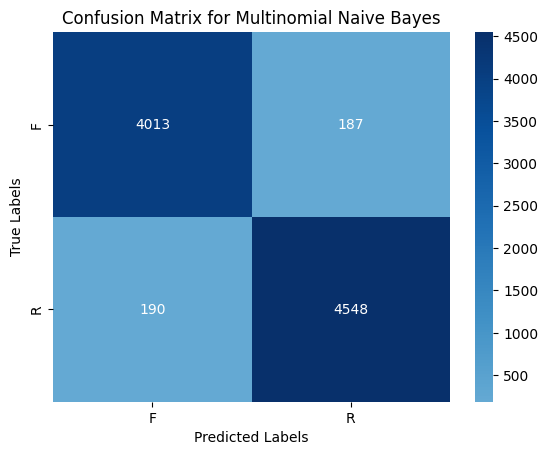

array([[4013,  187],
       [ 190, 4548]])

In [35]:
c_matrix = confusion_matrix(y_test, y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True,
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Multinomial Naive Bayes")
plt.show()
c_matrix

In [36]:
multi_nb_model_classification_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report of Multinomial Naive Bayes\n", multi_nb_model_classification_report)

Classification Report of Multinomial Naive Bayes
               precision    recall  f1-score   support

           F       0.95      0.96      0.96      4200
           R       0.96      0.96      0.96      4738

    accuracy                           0.96      8938
   macro avg       0.96      0.96      0.96      8938
weighted avg       0.96      0.96      0.96      8938



#### Logistic Regression Model

In [37]:
# Find the best parameter for LR, and TF-IDF

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'lr__C': [0.01, 0.1, 1, 10],
#     'lr__solver': ['liblinear', 'saga'],
# }

# grid = GridSearchCV(
#     lr_model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === Output ===
# Best Parameters: {'lr__C': 10, 'lr__solver': 'liblinear', 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
# Best Cross-Validation Score: 0.9961120093722527

In [38]:
lr_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,1),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
    )),
    ("lr", LogisticRegression(
        C=10,
        solver='liblinear',
        random_state=44,
        max_iter=10000,
    )),
])

lr_model.fit(x_train, y_train)

,steps,"[('tfidf', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


Logistic Regression Model Check

In [39]:
print("Pipeline Model Train Score:", lr_model.score(x_train, y_train))
print("Pipeline Model Test Score:", lr_model.score(x_test, y_test))

Pipeline Model Train Score: 0.9997482587899639
Pipeline Model Test Score: 0.9960841351532781


In [40]:
# lr_best_model = grid.best_estimator_

y_pred = lr_model.predict(x_test)
df = pd.DataFrame()
df["Actual"], df["Predict"] = y_test, y_pred
df.replace(0, "R", inplace=True)
df.replace(1, "F", inplace=True)
df

,Actual,Predict
17896,F,F
16186,R,R
12959,R,R
21764,F,F
7557,F,F
...,...,...
16296,F,F
4455,R,R
13633,F,F
9704,R,R


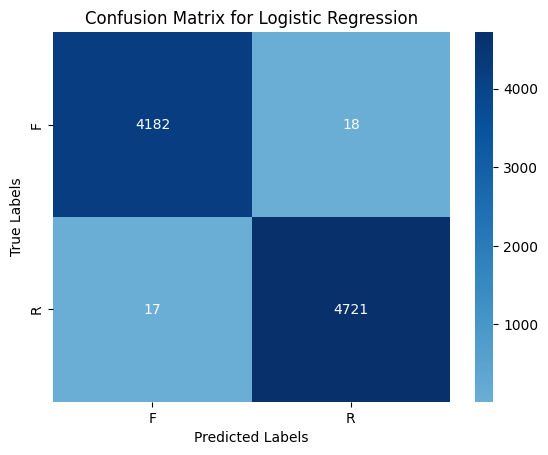

array([[4182,   18],
       [  17, 4721]])

In [41]:
c_matrix = confusion_matrix(y_test, y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True,
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()
c_matrix

In [42]:
lr_classification_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report of Logistic Regression\n", lr_classification_report)

Classification Report of Logistic Regression
               precision    recall  f1-score   support

           F       1.00      1.00      1.00      4200
           R       1.00      1.00      1.00      4738

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



#### Random Tree Forest Model

In [43]:
# Find the best parameter for RTF

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'rfc__n_estimators': [100, 300, 500],
#     'rfc__max_depth': [None, 30, 50],
#     'rfc__min_samples_split': [2, 5],
# }

# grid = GridSearchCV(
#     rf_model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === Output ===
# Best Parameters: {'rfc__max_depth': None, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 300, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
# Best Cross-Validation Score: 0.9933708210402379

In [44]:
rf_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,1),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
    )),
    ("rfc", RandomForestClassifier(
        criterion='gini',
        max_depth=None,
        n_estimators=300,
        min_samples_split=2,
        random_state=44,
    )),
])

rf_model.fit(x_train, y_train)

,steps,"[('tfidf', ...), ('rfc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


Random Forest Model Check

In [45]:
print("Pipeline Model Train Score: ", rf_model.score(x_train, y_train))
print("Pipeline Model Test Score: ", rf_model.score(x_test, y_test))

Pipeline Model Train Score:  0.9999720287544405
Pipeline Model Test Score:  0.9942940255090624


In [46]:
# rfc_best_model = grid.best_estimator_
y_pred = rf_model.predict(x_test)

df = pd.DataFrame()
df["Actual"], df["Predict"] = y_test, y_pred
df.replace(0, "R", inplace=True)
df.replace(1, "F", inplace=True)
df

,Actual,Predict
17896,F,F
16186,R,R
12959,R,R
21764,F,F
7557,F,F
...,...,...
16296,F,F
4455,R,R
13633,F,F
9704,R,R


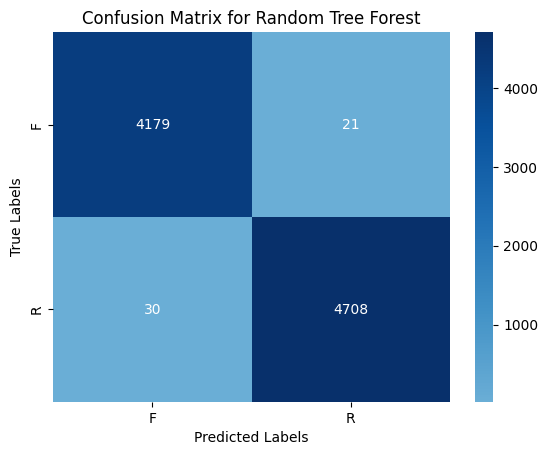

array([[4179,   21],
       [  30, 4708]])

In [47]:
c_matrix = confusion_matrix(y_test, y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True,
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Random Tree Forest")
plt.show()
c_matrix

In [48]:
rf_classification_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report of Random Tree Forest\n", rf_classification_report)

Classification Report of Random Tree Forest
               precision    recall  f1-score   support

           F       0.99      0.99      0.99      4200
           R       1.00      0.99      0.99      4738

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



#### Support Vector Machine Model

In [49]:
# Find the best parameter for SVM

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'sv__C': [0.01, 0.1, 1, 10],
#     'sv__max_iter': [1000, 2000, 5000],
#     'sv__class_weight': [None, 'balanced'],
# }

# grid = GridSearchCV(
#     svc_model,
#     param_grid=param_grid,
#     cv=5,
#     scoring='f1_macro',
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === Output ===
# Best Parameters: {'sv__C': 10, 'sv__class_weight': None, 'sv__max_iter': 1000, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 1)}
# Best Cross-Validation Score: 0.9968320978198741

In [50]:
svc_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,1),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
    )),
    ("sv", LinearSVC(
        C=10,
        class_weight=None,
        max_iter=1000,
        random_state=44
    )),
])

svc_model.fit(x_train, y_train)

,steps,"[('tfidf', ...), ('sv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


SVM Model Check

In [51]:
print("Pipeline Model Train Score: ", svc_model.score(x_train, y_train))
print("Pipeline Model Test Score: ", svc_model.score(x_test, y_test))

Pipeline Model Train Score:  0.9999720287544405
Pipeline Model Test Score:  0.99742671738644


In [52]:
y_pred = svc_model.predict(x_test)

df = pd.DataFrame()
df["Actual"], df["Predict"] = y_test, y_pred
df.replace(0, "R", inplace=True)
df.replace(1, "F", inplace=True)
df

,Actual,Predict
17896,F,F
16186,R,R
12959,R,R
21764,F,F
7557,F,F
...,...,...
16296,F,F
4455,R,R
13633,F,F
9704,R,R


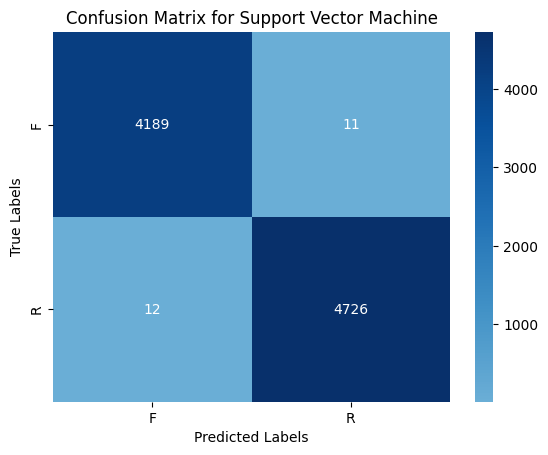

array([[4189,   11],
       [  12, 4726]])

In [53]:
c_matrix = confusion_matrix(y_test, y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True,
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Support Vector Machine")
plt.show()
c_matrix

In [54]:
linear_svc_classification_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report of Support Vector Machine\n", linear_svc_classification_report)

Classification Report of Support Vector Machine
               precision    recall  f1-score   support

           F       1.00      1.00      1.00      4200
           R       1.00      1.00      1.00      4738

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



#### Show Results of Each Machine Learning Model

In [55]:
nb_pred = multi_nb_model.predict(x_test)
lr_pred = lr_model.predict(x_test)
rf_pred = rf_model.predict(x_test)
svc_pred = svc_model.predict(x_test)

results = pd.DataFrame({
    "Model": ["SVM", "Logistic Regression", "Random Forest", "Naive Bayes"],
    "Accuracy": [
        accuracy_score(y_test, svc_pred),
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, nb_pred),
    ],
    "Precision": [
        precision_score(y_test, svc_pred),
        precision_score(y_test, lr_pred),
        precision_score(y_test, rf_pred),
        precision_score(y_test, nb_pred),
    ],
    "Recall": [
        recall_score(y_test, svc_pred),
        recall_score(y_test, lr_pred),
        recall_score(y_test, rf_pred),
        recall_score(y_test, nb_pred),
    ],
    "F1 Score": [
        f1_score(y_test, svc_pred),
        f1_score(y_test, lr_pred),
        f1_score(y_test, rf_pred),
        f1_score(y_test, nb_pred),
    ]
})

print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0                  SVM  0.997427   0.997678  0.997467  0.997573
1  Logistic Regression  0.996084   0.996202  0.996412  0.996307
2        Random Forest  0.994294   0.995559  0.993668  0.994613
3          Naive Bayes  0.957821   0.960507  0.959899  0.960203


Perform Cross Validation for each Model

In [56]:
models = {
    "Naive Bayes": multi_nb_model,
    "Logistic Regression": lr_model,
    "SVM": svc_model,
    "Random Forest": rf_model
}

for name, model in models.items():
    scores = cross_val_score(
        model,
        data_text.to_numpy(),
        data_target,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    print(f"{name} - Mean F1: {scores.mean():.4f} ± {scores.std():.4f}")

Naive Bayes - Mean F1: 0.9211 ± 0.0255
Logistic Regression - Mean F1: 0.9922 ± 0.0012
SVM - Mean F1: 0.9947 ± 0.0011
Random Forest - Mean F1: 0.9890 ± 0.0053


## Testing of Trained Model to Filipino Dataset

### Datasets

In [57]:
ph_url = "https://github.com/xRomory/CCMACLRL_COM231ML_PROJECT/blob/main/fake_news/datasets/filipino_news.csv?raw=true"
ph_data = pd.read_csv(ph_url)

ph_data.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


#### What's in the datasets?

In [58]:
ph_data.shape

(3206, 2)

In [59]:
ph_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3206 entries, 0 to 3205
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3206 non-null   int64 
 1   article  3206 non-null   object
dtypes: int64(1), object(1)
memory usage: 50.2+ KB


In [60]:
ph_data.describe(include=["object"]).T

,count,unique,top,freq
article,3206,3005,Usap-usapan ngayon sa social media ang umano'y...,91


In [61]:
# Check for missing values
ph_data.isna().sum()

label      0
article    0
dtype: int64

In [62]:
# Check for duplicated values
ph_data.duplicated().sum()

np.int64(201)

In [63]:
# See all instaces of duplicated rows
ph_data[ph_data.duplicated(keep=False)]

,label,article
4,0,Linisin ang Friendship Department dahil dadala...
16,0,"Sa madaling sabi, hindi 'happy' si WG dahil sa..."
19,0,"Hindi pumasa si Silva sa isang pre-fight exam,..."
20,0,"""We will implement the integration on February..."
28,0,Kasalo ng Elasto Painters ang defending champi...
...,...,...
2753,1,Usap-usapan ngayon sa social media ang umano'y...
2754,1,Usap-usapan ngayon sa social media ang umano'y...
2815,1,"Pinirmahan na ni Pangulong Duterte ang ""Mandat..."
2832,1,Sa debate ng mga senatorial aspirants sa progr...


In [64]:
# See label class distribution
ph_data.label.value_counts()

label
0    1603
1    1603
Name: count, dtype: int64

### PH Dataset Pre-processing

In [65]:
# Drop the duplicated values
ph_data.drop_duplicates(inplace=True)
ph_data.duplicated().sum()

np.int64(0)

In [66]:
ph_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3005 entries, 0 to 3205
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3005 non-null   int64 
 1   article  3005 non-null   object
dtypes: int64(1), object(1)
memory usage: 70.4+ KB


In [67]:
ph_data_text = ph_data["article"]
ph_data_text

0       Ayon sa TheWrap.com, naghain ng kaso si Krupa,...
1       Kilala rin ang singer sa pagkumpas ng kanyang ...
2       BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...
3       Kasama sa programa ang pananalangin, bulaklak ...
4       Linisin ang Friendship Department dahil dadala...
                              ...                        
3201    Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202    Sa isang pahayag, binatikos ng Liberal Party (...
3203    Panoorin nyo yung reaction video na ito ni Mr....
3204    Para sa mga magkakapatid na laging nagtatalo l...
3205    Grabe ibang klase talaga si Vice Ganda kung ma...
Name: article, Length: 3005, dtype: object

Text Normalization

In [68]:
import re

def normalize_text_filipino(text):
    # Removes mention `@user`
    text = re.sub(r'@\w+', '', text)

    # Removes URLs
    text = re.sub(r'http\S+', '', text)

    # Remove "Source:" or similar tags
    text = re.sub(r"source\s*:\s*\w+", "", text, flags=re.IGNORECASE)

    # Remove non-letter characters but keep Filipino and accented chars
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    text = text.lower()

    return text.strip()

In [69]:
ph_data_text = ph_data_text.apply(normalize_text_filipino)
ph_data_text

0       ayon sa thewrapcom naghain ng kaso si krupa no...
1       kilala rin ang singer sa pagkumpas ng kanyang ...
2       blantyre malawi ap bumiyahe patungong malawi s...
3       kasama sa programa ang pananalangin bulaklak a...
4       linisin ang friendship department dahil dadala...
                              ...                        
3201    hindi pa naienjoy ni giacomo filibeck ang pili...
3202    sa isang pahayag binatikos ng liberal party lp...
3203    panoorin nyo yung reaction video na ito ni mr ...
3204    para sa mga magkakapatid na laging nagtatalo l...
3205    grabe ibang klase talaga si vice ganda kung ma...
Name: article, Length: 3005, dtype: object

In [70]:
ph_data_target = ph_data["label"]
ph_data_target

0       0
1       0
2       0
3       0
4       0
       ..
3201    1
3202    1
3203    1
3204    1
3205    1
Name: label, Length: 3005, dtype: int64

#### Testing of Trained Model to PH News Datasets

In [71]:
models = {
    "Naive Bayes": multi_nb_model,
    "Logistic Regression": lr_model,
    "SVM": svc_model,
    "Random Forest": rf_model
}

for name, model in models.items():
    ph_pred = model.predict(ph_data_text)
    acc = accuracy_score(ph_data_target, ph_pred)
    prec = precision_score(ph_data_target, ph_pred)
    rec_score = recall_score(ph_data_target, ph_pred)
    f1 = f1_score(ph_data_target, ph_pred)

    print(f"=== {name} on Filipino Dataset ===")
    print(f"{name} Accuracy on Filipino Dataset: {acc:.4f}")
    print(f"{name} Precision on Filipino Dataset: {prec:.4f}")
    print(f"{name} Recall on Filipino Dataset: {rec_score:.4f}")
    print(f"{name} F1 Score on Filipino Dataset: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(ph_data_target, ph_pred, digits=4, zero_division=1))

=== Naive Bayes on Filipino Dataset ===
Naive Bayes Accuracy on Filipino Dataset: 0.4379
Naive Bayes Precision on Filipino Dataset: 0.4045
Naive Bayes Recall on Filipino Dataset: 0.2525
Naive Bayes F1 Score on Filipino Dataset: 0.3109

Classification Report:
              precision    recall  f1-score   support

           0     0.4532    0.6250    0.5254      1496
           1     0.4045    0.2525    0.3109      1509

    accuracy                         0.4379      3005
   macro avg     0.4288    0.4387    0.4182      3005
weighted avg     0.4287    0.4379    0.4177      3005

=== Logistic Regression on Filipino Dataset ===
Logistic Regression Accuracy on Filipino Dataset: 0.5022
Logistic Regression Precision on Filipino Dataset: 0.5022
Logistic Regression Recall on Filipino Dataset: 1.0000
Logistic Regression F1 Score on Filipino Dataset: 0.6686

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.0000    0.0000      1496
      

#### Results Data Visualization

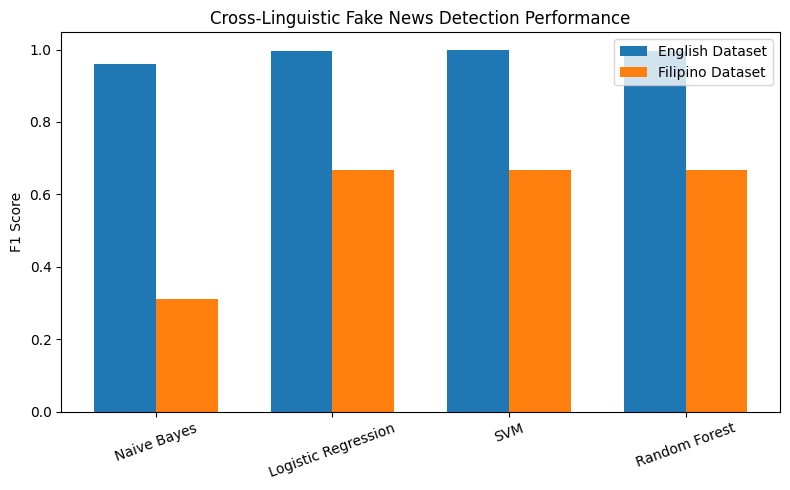

In [72]:
models = ["Naive Bayes", "Logistic Regression", "SVM", "Random Forest"]
english_f1 = [0.9602, 0.9963, 0.9976, 0.9946]
filipino_f1 = [0.3109, 0.6686, 0.6680, 0.6662]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, english_f1, width, label="English Dataset")
plt.bar(x + width/2, filipino_f1, width, label="Filipino Dataset")

plt.ylabel("F1 Score")
plt.title("Cross-Linguistic Fake News Detection Performance")
plt.xticks(x, models, rotation=20)
plt.legend()
plt.tight_layout()
plt.show()

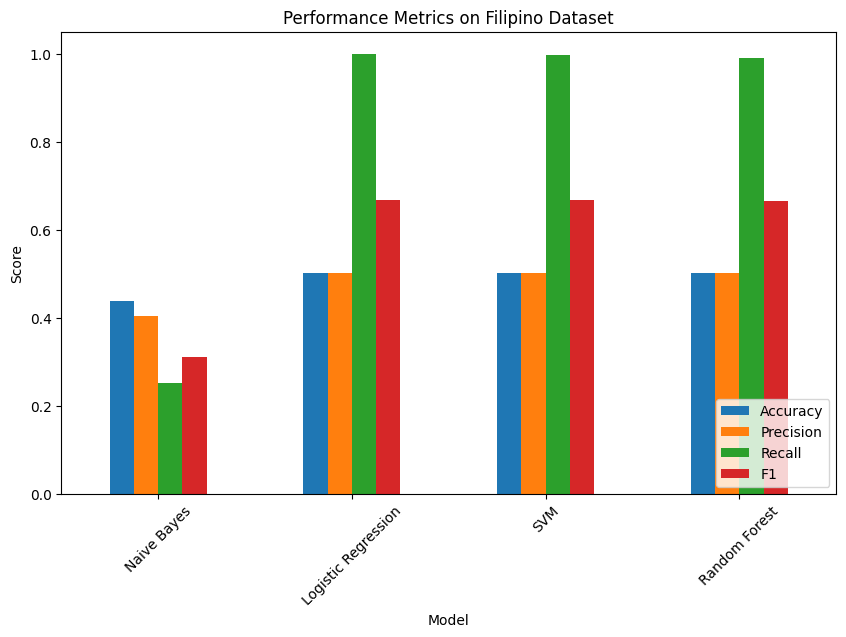

In [73]:
metrics = pd.DataFrame({
    "Model": models,
    "Accuracy": [0.4379, 0.5022, 0.5018, 0.5012],
    "Precision": [0.4045, 0.5022, 0.5020, 0.5017],
    "Recall": [0.2525, 1.0000, 0.9980, 0.9914],
    "F1": [0.3109, 0.6686, 0.6680, 0.6662]
})

metrics.plot(x="Model", kind="bar", figsize=(10,6))
plt.title("Performance Metrics on Filipino Dataset")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

Statiscally and visually, we can see a significant drop on the models' performance when tested to a Filipino datasets

## Retrain Models using Filipino Fake News Datasets

#### Data Pre-processing

In [74]:
ph_data_text = ph_data["article"]
ph_data_text

0       Ayon sa TheWrap.com, naghain ng kaso si Krupa,...
1       Kilala rin ang singer sa pagkumpas ng kanyang ...
2       BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...
3       Kasama sa programa ang pananalangin, bulaklak ...
4       Linisin ang Friendship Department dahil dadala...
                              ...                        
3201    Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202    Sa isang pahayag, binatikos ng Liberal Party (...
3203    Panoorin nyo yung reaction video na ito ni Mr....
3204    Para sa mga magkakapatid na laging nagtatalo l...
3205    Grabe ibang klase talaga si Vice Ganda kung ma...
Name: article, Length: 3005, dtype: object

Text normalization but leaning more in Filipino language

In [75]:
import re

# We can still add more
filipino_stopwords = set([
    "ang", "ng", "sa", "mga", "ay", "at", "na", "ni", "si", "kay", "para", "ito", "iyon", "ko", "mo", "kayo", "tayo", "kami", "sila", "nila", "natin", "namin", "kanila"
])


def normalize_text_filipino(text):
    # Removes mention `@user`
    text = re.sub(r'@\w+', '', text)

    # Removes URLs
    text = re.sub(r'http\S+', '', text)

    # Remove "Source:" or similar tags
    text = re.sub(r"source\s*:\s*\w+", "", text, flags=re.IGNORECASE)

    # Remove non-letter characters but keep Filipino and accented chars
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    text = text.lower()

    # Remove Filipino stopwords
    words = [word for word in text.split() if word not in filipino_stopwords]
    return " ".join(words).strip()

In [76]:
ph_data_text = ph_data_text.apply(normalize_text_filipino)
ph_data_text

0       ayon thewrapcom naghain kaso krupa noong huweb...
1       kilala rin singer pagkumpas kanyang kamay tuwi...
2       blantyre malawi ap bumiyahe patungong malawi m...
3       kasama programa pananalangin bulaklak pagsindi...
4       linisin friendship department dahil dadalawin ...
                              ...                        
3201    hindi pa naienjoy giacomo filibeck pilipinas a...
3202    isang pahayag binatikos liberal party lp pagku...
3203    panoorin nyo yung reaction video mr claro the ...
3204    magkakapatid laging nagtatalo lalo noong bata ...
3205    grabe ibang klase talaga vice ganda kung magpa...
Name: article, Length: 3005, dtype: object

In [77]:
ph_x_train, ph_x_test, ph_y_train, ph_y_test = train_test_split(
    ph_data_text,
    ph_data_target,
    test_size=0.2,
    random_state=42
)

print("x_train Shape:", ph_x_train.shape)
print("x_test Shape:", ph_x_test.shape)
print("y_train Shape:", ph_y_train.shape)
print("y_test Shape:", ph_y_test.shape)

x_train Shape: (2404,)
x_test Shape: (601,)
y_train Shape: (2404,)
y_test Shape: (601,)


## Train Models

#### MultinomialNB Model

In [78]:
# Find the best parameter for MNB, and TF-IDF

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__min_df': [3, 4, 5],
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'mnb__alpha': [0.1, 0.5, 1],
#     'mnb__fit_prior': [True, False],
# }

# grid = GridSearchCV(
#     ph_multi_nb_model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(ph_x_train, ph_y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === Output ===
# Best Parameters: {'mnb__alpha': 0.1, 'mnb__fit_prior': False, 'tfidf__max_df': 0.7, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
# Best Cross-Validation Score: 0.9222115384615386

In [79]:
ph_multi_nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.7,
        sublinear_tf=True,
    )),
    ("mnb", MultinomialNB(
        alpha=0.1,
        fit_prior=False,
    )),
])

ph_multi_nb_model.fit(ph_x_train, ph_y_train)

,steps,"[('tfidf', ...), ('mnb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [80]:
print("Pipeline Model Train Score: ", ph_multi_nb_model.score(ph_x_train, ph_y_train))
print("Pipeline Model Test Score: ", ph_multi_nb_model.score(ph_x_test, ph_y_test))

Pipeline Model Train Score:  0.9816971713810316
Pipeline Model Test Score:  0.9334442595673876


In [81]:
ph_y_pred = ph_multi_nb_model.predict(ph_x_test)

df = pd.DataFrame()
df["Actual"], df["Predict"] = ph_y_test, ph_y_pred
df.replace(0, "R", inplace=True)
df.replace(1, "F", inplace=True)
df

,Actual,Predict
443,R,R
1981,F,F
2829,F,R
2688,F,F
1613,F,F
...,...,...
2581,F,R
706,R,R
1768,F,F
2264,F,F


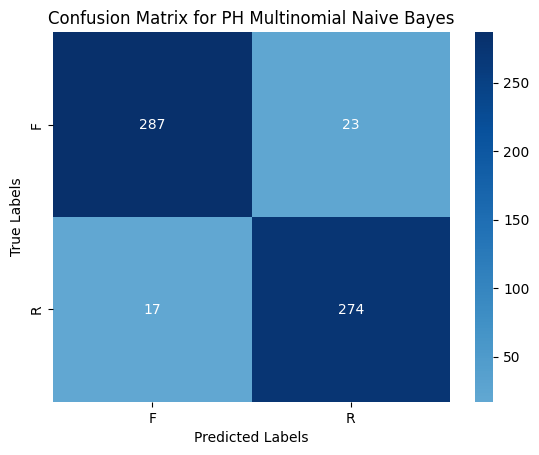

array([[287,  23],
       [ 17, 274]])

In [82]:
c_matrix = confusion_matrix(ph_y_test, ph_y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True,
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for PH Multinomial Naive Bayes")
plt.show()
c_matrix

In [83]:
ph_multi_nb_model_classification_report = classification_report(ph_y_test, ph_y_pred, target_names=target_names)
print("Classification Report of Multinomial Naive Bayes\n", ph_multi_nb_model_classification_report)

Classification Report of Multinomial Naive Bayes
               precision    recall  f1-score   support

           F       0.94      0.93      0.93       310
           R       0.92      0.94      0.93       291

    accuracy                           0.93       601
   macro avg       0.93      0.93      0.93       601
weighted avg       0.93      0.93      0.93       601



#### Logistic Regression Model

In [84]:
# Find the best parameter for LR, and TF-IDF

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__min_df': [3, 4, 5],
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'lr__C': [0.01, 0.1, 1, 10],
#     'lr__solver': ['liblinear', 'saga'],
# }

# grid = GridSearchCV(
#     lr_model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(ph_x_train, ph_y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === Output ===
# Best Parameters: {'lr__C': 10, 'lr__solver': 'liblinear', 'tfidf__max_df': 0.8, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
# Best Cross-Validation Score: 0.9613115038115039

In [85]:
ph_lr_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.8,
        sublinear_tf=True,
    )),
    ("lr", LogisticRegression(
        C=10,
        solver='liblinear',
        random_state=44,
        max_iter=10000,
    )),
])

ph_lr_model.fit(ph_x_train, ph_y_train)

,steps,"[('tfidf', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [86]:
print("Pipeline Model Train Score: ", ph_lr_model.score(ph_x_train, ph_y_train))
print("Pipeline Model Test Score: ", ph_lr_model.score(ph_x_test, ph_y_test))

Pipeline Model Train Score:  1.0
Pipeline Model Test Score:  0.9750415973377704


In [87]:
ph_y_pred = ph_lr_model.predict(ph_x_test)

df = pd.DataFrame()
df["Actual"], df["Predict"] = ph_y_test, ph_y_pred
df.replace(0, "R", inplace=True)
df.replace(1, "F", inplace=True)
df

,Actual,Predict
443,R,R
1981,F,F
2829,F,R
2688,F,F
1613,F,F
...,...,...
2581,F,R
706,R,R
1768,F,F
2264,F,F


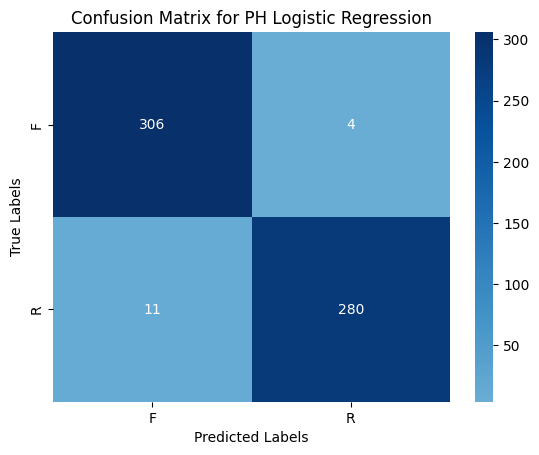

array([[306,   4],
       [ 11, 280]])

In [88]:
c_matrix = confusion_matrix(ph_y_test, ph_y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True,
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for PH Logistic Regression")
plt.show()
c_matrix

In [89]:
ph_lr_model_classification_report = classification_report(ph_y_test, ph_y_pred, target_names=target_names)
print("Classification Report of Logistic Regression\n", ph_lr_model_classification_report)

Classification Report of Logistic Regression
               precision    recall  f1-score   support

           F       0.97      0.99      0.98       310
           R       0.99      0.96      0.97       291

    accuracy                           0.98       601
   macro avg       0.98      0.97      0.97       601
weighted avg       0.98      0.98      0.98       601



#### Random Tree Forest Model

In [90]:
# Find the best parameter for RTF

# # === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__min_df': [3, 4, 5],
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'rfc__n_estimators': [300, 500, 1000],
#     'rfc__max_depth': [None, 30, 50],
#     'rfc__min_samples_split': [2, 5],
#     'rfc__min_samples_leaf': [1, 2, 5],
#     'rfc__max_features': ['sqrt', 'log2'],
#     'rfc__class_weight': [None, 'balanced']
# }

# grid = GridSearchCV(
#     ph_rtf_model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(ph_x_train, ph_y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === OUTPUT ===
# Best Parameters: {'rfc__class_weight': None, 'rfc__max_depth': 50, 'rfc__max_features': 'sqrt', 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 500, 'tfidf__max_df': 0.7, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
# Best Cross-Validation Score: 0.9351056826056826

In [91]:
ph_rtf_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.7,
        sublinear_tf=True,
    )),
    ("rfc", RandomForestClassifier(
        max_depth=50,
        criterion='gini',
        min_samples_split=2,
        n_estimators=500,
        random_state=44,
        max_features='sqrt',
        min_samples_leaf=1
    )),
])

ph_rtf_model.fit(ph_x_train, ph_y_train)

,steps,"[('tfidf', ...), ('rfc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [92]:
print("Pipeline Model Train Score: ", ph_rtf_model.score(ph_x_train, ph_y_train))
print("Pipeline Model Test Score: ", ph_rtf_model.score(ph_x_test, ph_y_test))

Pipeline Model Train Score:  0.9991680532445923
Pipeline Model Test Score:  0.956738768718802


In [93]:
ph_y_pred = ph_rtf_model.predict(ph_x_test)

df = pd.DataFrame()
df["Actual"], df["Predict"] = ph_y_test, ph_y_pred
df.replace(0, "R", inplace=True)
df.replace(1, "F", inplace=True)
df

,Actual,Predict
443,R,R
1981,F,F
2829,F,R
2688,F,F
1613,F,F
...,...,...
2581,F,F
706,R,R
1768,F,F
2264,F,F


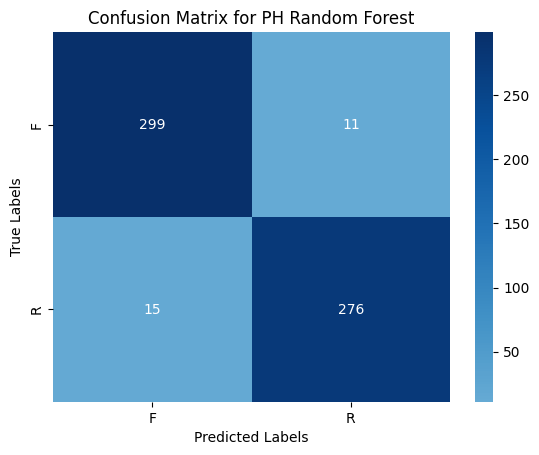

array([[299,  11],
       [ 15, 276]])

In [94]:
c_matrix = confusion_matrix(ph_y_test, ph_y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True,
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for PH Random Forest")
plt.show()
c_matrix

In [95]:
ph_rtf_model_classification_report = classification_report(ph_y_test, ph_y_pred, target_names=target_names)
print("Classification Report of Random Forest Tree\n", ph_rtf_model_classification_report)

Classification Report of Random Forest Tree
               precision    recall  f1-score   support

           F       0.95      0.96      0.96       310
           R       0.96      0.95      0.96       291

    accuracy                           0.96       601
   macro avg       0.96      0.96      0.96       601
weighted avg       0.96      0.96      0.96       601



#### SVM Model

In [96]:
# Find the best parameter for SVM

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__min_df': [3, 4, 5],
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'sv__C': [0.01, 0.1, 1, 10],
#     'sv__max_iter': [1000, 2000, 5000],
#     'sv__class_weight': [None, 'balanced'],
# }

# grid = GridSearchCV(
#     ph_svc_model,
#     param_grid=param_grid,
#     cv=5,
#     scoring='f1_macro',
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(ph_x_train, ph_y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === OUTPUT ===
# Best Parameters: {'sv__C': 1, 'sv__class_weight': 'balanced', 'sv__max_iter': 1000, 'tfidf__max_df': 0.9, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}
# Best Cross-Validation Score: 0.9671343125136211

In [97]:
ph_svc_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=4,
        max_df=0.9,
        sublinear_tf=True,
    )),
    ("sv", LinearSVC(
        C=1,
        class_weight='balanced',
        max_iter=1000,
        random_state=44
    )),
])

ph_svc_model.fit(ph_x_train, ph_y_train)

,steps,"[('tfidf', ...), ('sv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [98]:
print("Pipeline Model Train Score: ", ph_svc_model.score(ph_x_train, ph_y_train))
print("Pipeline Model Test Score: ", ph_svc_model.score(ph_x_test, ph_y_test))

Pipeline Model Train Score:  1.0
Pipeline Model Test Score:  0.9750415973377704


In [99]:
ph_y_pred = ph_rtf_model.predict(ph_x_test)

df = pd.DataFrame()
df["Actual"], df["Predict"] = ph_y_test, ph_y_pred
df.replace(0, "R", inplace=True)
df.replace(1, "F", inplace=True)
df

,Actual,Predict
443,R,R
1981,F,F
2829,F,R
2688,F,F
1613,F,F
...,...,...
2581,F,F
706,R,R
1768,F,F
2264,F,F


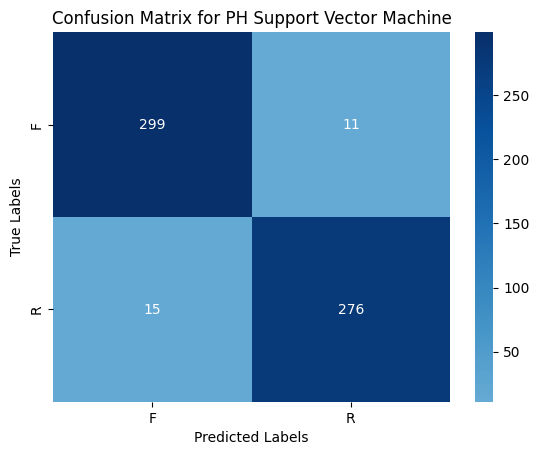

array([[299,  11],
       [ 15, 276]])

In [100]:
c_matrix = confusion_matrix(ph_y_test, ph_y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True,
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for PH Support Vector Machine")
plt.show()
c_matrix

In [101]:
ph_svc_model_classification_report = classification_report(ph_y_test, ph_y_pred, target_names=target_names)
print("Classification Report of Random Forest Tree\n", ph_svc_model_classification_report)

Classification Report of Random Forest Tree
               precision    recall  f1-score   support

           F       0.95      0.96      0.96       310
           R       0.96      0.95      0.96       291

    accuracy                           0.96       601
   macro avg       0.96      0.96      0.96       601
weighted avg       0.96      0.96      0.96       601



### Show Results of Each Machine Learning Models

In [102]:
ph_nb_pred = ph_multi_nb_model.predict(ph_x_test)
ph_lr_pred = ph_lr_model.predict(ph_x_test)
ph_rf_pred = ph_rtf_model.predict(ph_x_test)
ph_svc_pred = ph_svc_model.predict(ph_x_test)

results = pd.DataFrame({
    "Model": ["SVM", "Logistic Regression", "Random Forest", "Naive Bayes"],
    "Accuracy": [
        accuracy_score(ph_y_test, ph_svc_pred),
        accuracy_score(ph_y_test, ph_lr_pred),
        accuracy_score(ph_y_test, ph_rf_pred),
        accuracy_score(ph_y_test, ph_nb_pred),
    ],
    "Precision": [
        precision_score(ph_y_test, ph_svc_pred),
        precision_score(ph_y_test, ph_lr_pred),
        precision_score(ph_y_test, ph_rf_pred),
        precision_score(ph_y_test, ph_nb_pred),
    ],
    "Recall": [
        recall_score(ph_y_test, ph_svc_pred),
        recall_score(ph_y_test, ph_lr_pred),
        recall_score(ph_y_test, ph_rf_pred),
        recall_score(ph_y_test, ph_nb_pred),
    ],
    "F1 Score": [
        f1_score(ph_y_test, ph_svc_pred),
        f1_score(ph_y_test, ph_lr_pred),
        f1_score(ph_y_test, ph_rf_pred),
        f1_score(ph_y_test, ph_nb_pred),
    ]
})

print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0                  SVM  0.975042   0.985915  0.962199  0.973913
1  Logistic Regression  0.975042   0.985915  0.962199  0.973913
2        Random Forest  0.956739   0.961672  0.948454  0.955017
3          Naive Bayes  0.933444   0.922559  0.941581  0.931973


### Perform Cross Validation for each Machine Learning Models

In [103]:
ph_models = {
    "Naive Bayes": ph_multi_nb_model,
    "Logistic Regression": ph_lr_model,
    "SVM": ph_svc_model,
    "Random Forest": ph_rtf_model
}

for name, model in ph_models.items():
    scores = cross_val_score(
        model,
        ph_data_text.to_numpy(),
        ph_data_target,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    print(f"{name} - Mean F1: {scores.mean():.4f} ± {scores.std():.4f}")

Naive Bayes - Mean F1: 0.9109 ± 0.0576
Logistic Regression - Mean F1: 0.9284 ± 0.0689
SVM - Mean F1: 0.9331 ± 0.0650
Random Forest - Mean F1: 0.9158 ± 0.0666


In [104]:
ph_models = {
    "Naive Bayes": ph_multi_nb_model,
    "Logistic Regression": ph_lr_model,
    "SVM": ph_svc_model,
    "Random Forest": ph_rtf_model
}

for name, model in ph_models.items():
    ph_pred = model.predict(ph_x_test)
    acc = accuracy_score(ph_y_test, ph_pred)
    prec = precision_score(ph_y_test, ph_pred)
    rec_score = recall_score(ph_y_test, ph_pred)
    f1 = f1_score(ph_y_test, ph_pred)

    print(f"=== Trained {name} on Filipino Dataset ===")
    print(f"{name} Accuracy on Filipino Dataset: {acc:.4f}")
    print(f"{name} Precision on Filipino Dataset: {prec:.4f}")
    print(f"{name} Recall on Filipino Dataset: {rec_score:.4f}")
    print(f"{name} F1 Score on Filipino Dataset: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(ph_y_test, ph_pred, digits=4, zero_division=1))

=== Trained Naive Bayes on Filipino Dataset ===
Naive Bayes Accuracy on Filipino Dataset: 0.9334
Naive Bayes Precision on Filipino Dataset: 0.9226
Naive Bayes Recall on Filipino Dataset: 0.9416
Naive Bayes F1 Score on Filipino Dataset: 0.9320

Classification Report:
              precision    recall  f1-score   support

           0     0.9441    0.9258    0.9349       310
           1     0.9226    0.9416    0.9320       291

    accuracy                         0.9334       601
   macro avg     0.9333    0.9337    0.9334       601
weighted avg     0.9337    0.9334    0.9335       601

=== Trained Logistic Regression on Filipino Dataset ===
Logistic Regression Accuracy on Filipino Dataset: 0.9750
Logistic Regression Precision on Filipino Dataset: 0.9859
Logistic Regression Recall on Filipino Dataset: 0.9622
Logistic Regression F1 Score on Filipino Dataset: 0.9739

Classification Report:
              precision    recall  f1-score   support

           0     0.9653    0.9871    0.9761 